# EPICS4 PV access example

Outside of this Jupyter notebook
- start the GUI, which will start the P4P server
```bash
$ python scripts/devGui.py --ip <RFSOC_IP_ADDDRESS>
```

In [1]:
# setup the P4P client
# https://mdavidsaver.github.io/p4p/client.html#usage
import numpy as np
import time
import matplotlib.pyplot as plt
from p4p.client.thread import Context
print( Context.providers() )
ctxt = Context('pva')

['pva']


In [2]:
# Get the FPGA firmware Version
# https://github.com/slaclab/darpa-accel-llrf-phase-1p5/blob/main/firmware/targets/shared_version.mk#L2
hex(ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:FpgaVersion' ))

'0x2000000'

In [3]:
# Put/Get the debug scratch pad
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L47
ctxt.put( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:ScratchPad', 0x12345678 )
hex(ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:ScratchPad' ))

'0x12345678'

In [4]:
# Get the UpTimeCnt (units of seconds) 
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L58
ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:UpTimeCnt' )

185

In [5]:
# Get the UpTime ('HH:MM:SS')
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L80
ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:UpTime' )

'0:03:05'

In [6]:
# Get the GitHash
# https://github.com/slaclab/surf/blob/master/python/surf/axi/_AxiVersion.py#L179
ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:GitHash' )

'0xb3172676b98468e3dc4e681255f0a07415e64eea'

In [7]:
# Wait for DSP Clock to be stable after changing NCO value
def WaitDspClkStable():
    while( ctxt.get( 'rfsoc_ioc:Root:RFSoC:AxiSocCore:AxiVersion:DspReset' )):
        time.sleep(0.01)

# Function for Setting DAC NCO only (units of MHz)
def SetDacNco(ncoFreqMhz,ch):
    # DAC is a "quad" tile, so only 1 NCO value to set in the RF Tile's RF block
    if ch==0:
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:dacTile[2]:dacBlock[0]:ncoFrequency', ncoFreqMhz)
    else:
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:dacTile[0]:dacBlock[0]:ncoFrequency', ncoFreqMhz)
    WaitDspClkStable()  

# Function for Setting ADC NCO only (units of MHz)
def SetAdcNco(ncoFreqMhz,ch):
    # ADC is a "dual" tile, so only 2 NCO value (odd/even) to set in the RF Tile's RF block
    if ch==0:
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[2]:adcBlock[2]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Odd
        WaitDspClkStable()
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[2]:adcBlock[3]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Even
    elif ch==1:
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[2]:adcBlock[0]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Odd
        WaitDspClkStable()
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[2]:adcBlock[1]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Even
    elif ch==2:
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[0]:adcBlock[2]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Odd
        WaitDspClkStable()
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[0]:adcBlock[3]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Even
    else:
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[0]:adcBlock[0]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Odd
        WaitDspClkStable()
        ctxt.put( 'rfsoc_ioc:Root:RFSoC:RfDataConverter:adcTile[0]:adcBlock[1]:ncoFrequency', ncoFreqMhz) # ncoPhaseMode=Even
    WaitDspClkStable()

# Function to trigger the waveform ring buffers
def TrigRingBuffer():
    ctxt.put( 'rfsoc_ioc:Root:Waveform:Updated', 0)
    time.sleep(0.1)
    ctxt.put( 'rfsoc_ioc:Root:RFSoC:Application:SoftDacTrigRaw', 1)

    # Wait for Waveform
    while( ctxt.get( 'rfsoc_ioc:Root:Waveform:Updated') != True):
        time.sleep(0.01)

# Function to plot the ADC/DAC waveforms
def PlotWavform(type,ch):
    fig, axs = plt.subplots(3)
    axs[0].plot(ctxt.get('rfsoc_ioc:Root:Waveform:Time'),ctxt.get(f'rfsoc_ioc:Root:Waveform:{type}I[{ch}]'))
    axs[0].set_ylabel(f'{type}[{ch}].I') 
    axs[1].plot(ctxt.get('rfsoc_ioc:Root:Waveform:Time'),ctxt.get(f'rfsoc_ioc:Root:Waveform:{type}Q[{ch}]'))
    axs[1].set_ylabel(f'{type}[{ch}].Q') 
    axs[2].plot(ctxt.get('rfsoc_ioc:Root:Waveform:Time'),ctxt.get(f'rfsoc_ioc:Root:Waveform:{type}Mag[{ch}]'))
    axs[2].set_ylabel(f'{type}[{ch}].Mag')  
    axs[2].set_xlabel("Time (ns)")
    [axs[i].grid() for i in range(3)]

# Function to trigger then plot waveforms
def TriggerThenPlotWavform():  
    TrigRingBuffer()
    for i in range(4):
        PlotWavform(type='Adc',ch=i)
    for i in range(2):        
        PlotWavform(type='Dac',ch=i)   

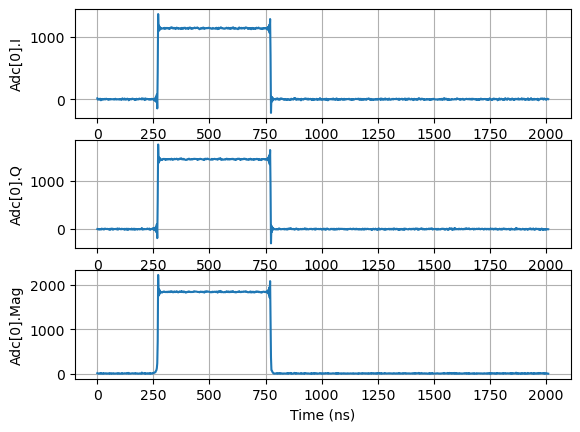

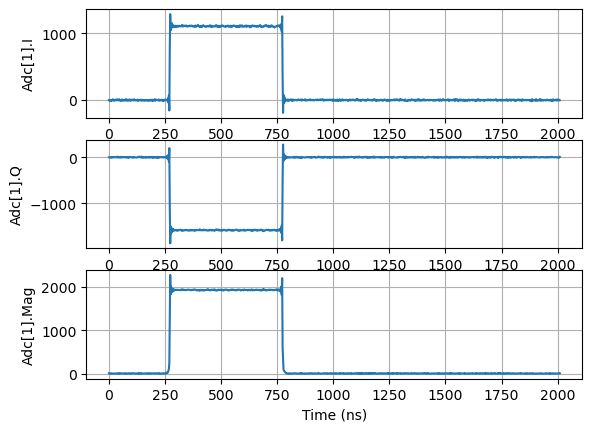

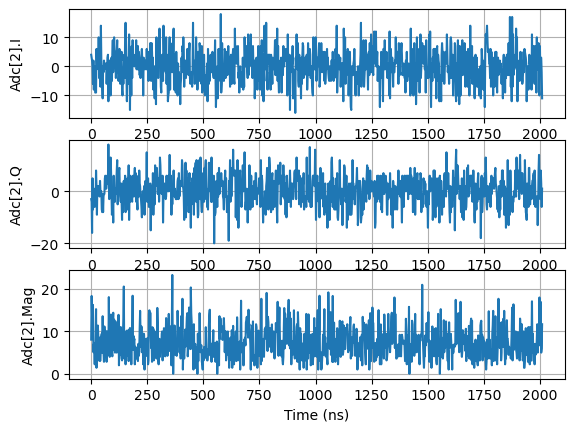

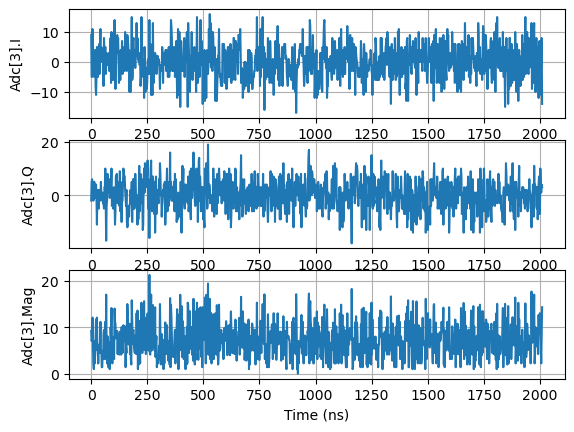

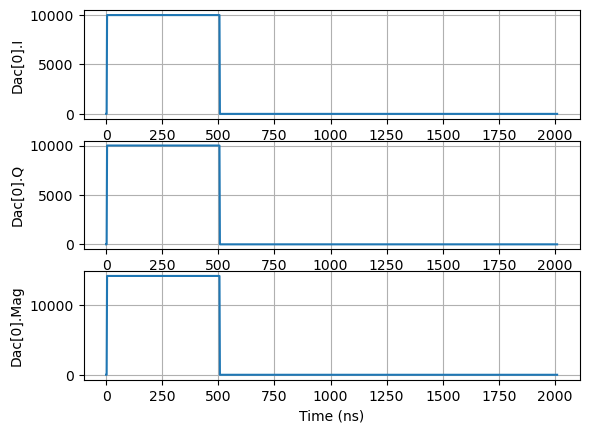

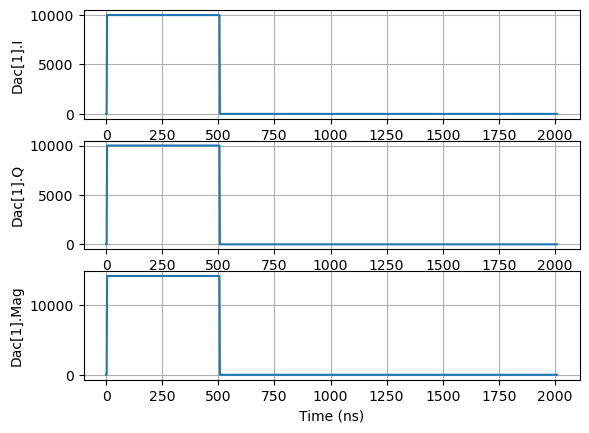

In [8]:
# Set both ADC and DAC to use a 1000 MHz NCO for digital RF mixing
SetAdcNco(ncoFreqMhz=1000.0,ch=0)
SetDacNco(ncoFreqMhz=1000.0,ch=0)

# Then trigger then plot waveforms
TriggerThenPlotWavform()